# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [3]:
# Predetermined columns to keep from starter code
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status (unsure if they are high or low-risk)
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [5]:
# look at distribution of loan status (small sample size of high risk loans)
df["loan_status"].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [6]:
# look at the categorical value columns that need to be converted to numeric values
columns_obj = df.select_dtypes(include='object').columns
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [7]:
# look at all columns
for column in df[columns_obj]:
    print(column, "\n", df[column].value_counts())
    print("-----------------------------")

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
-----------------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
-----------------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
-----------------------------
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
-----------------------------
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
-----------------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
-----------------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
-----------------------------
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64
-----------------------------
hard

In [8]:
# Drop all columns that only have one value in value_counts() (they dont provide info)
df = df.drop(columns=["debt_settlement_flag", "hardship_flag", "pymnt_plan"])
df.shape

(68817, 83)

In [9]:
# save df as clean_loans_df csv file
clean_loans_df = df
clean_loans_df.to_csv("clean_loans.csv",index=False)

# Split the Data into Training and Testing

In [10]:
# Create our features
X = clean_loans_df.drop(columns="loan_status")

# Create our target
y = clean_loans_df["loan_status"]

In [11]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [12]:
X.shape

(68817, 82)

In [13]:
# use get_dummies on remaining object columns to transform object dtypes into integer
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [14]:
# all columns in features X matrix
X_encoded.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [16]:
# Scale the X_encoded data
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[1]

array([ 0.80978726,  1.50182932,  1.55674724,  0.1452364 , -0.07664465,
       -0.30314253, -0.65649151,  0.73265606,  2.59496654,  0.034982  ,
        0.75767379,  0.82721145,  0.82731457, -0.07897941, -0.07880956,
        0.04272776, -0.51895465, -0.03227363,  0.        ,  0.        ,
        0.50475508, -0.12011247,  0.        ,  0.        , -0.01308545,
        0.37490228,  1.67997825, -0.09795141,  1.19137226,  0.70573978,
       -0.73738696, -0.01952023,  0.7515839 ,  1.87530974,  2.14887602,
       -0.19299287,  0.28642494,  0.21439255,  1.69641915,  2.56330882,
        0.33844742,  2.5982538 , -0.04563458,  0.61182906, -0.70912291,
       -0.07820908, -0.00778953, -0.6752617 ,  1.11814987, -0.76328999,
       -0.98044769,  0.31933256, -0.73807876,  0.54881075,  1.79153573,
        1.29596036,  1.54194528,  0.88677644,  1.21920657,  0.59413408,
        0.86399425,  0.55847015,  1.53973414,  0.73539329,  0.        ,
        0.        , -0.13347217,  1.99248491, -0.46330257,  0.57

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state=42)

In [18]:
from sklearn.linear_model import LogisticRegression

# Get a baseline of performance using the LogisticRegression classifier to make predictions
classifier = LogisticRegression(solver='lbfgs', random_state=42)

# train the model
classifier.fit(X_train, y_train)

# predict y using the model
y_pred = classifier.predict(X_test)

# view results in DF
pd.DataFrame({"Prediction":y_pred, "Actual":y_test})

,Prediction,Actual
1033,low_risk,low_risk
1219,low_risk,low_risk
62328,low_risk,low_risk
5966,low_risk,low_risk
24178,low_risk,low_risk
...,...,...
18266,low_risk,low_risk
9773,low_risk,low_risk
18052,low_risk,low_risk
5729,low_risk,low_risk


In [19]:
from sklearn.metrics import accuracy_score

# calculate accuracy
accuracy_score(y_test, y_pred)

0.9943039814007556

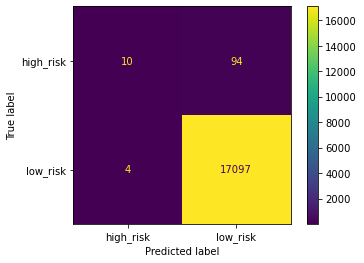

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, balanced_accuracy_score

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display it neatly
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
cm_disp.plot()

Base model only caught 10 out of 104 high risk loans...

In [21]:
# view classification report
c_report = classification_report(y_test, y_pred)
print(c_report)

              precision    recall  f1-score   support

   high_risk       0.71      0.10      0.17       104
    low_risk       0.99      1.00      1.00     17101

    accuracy                           0.99     17205
   macro avg       0.85      0.55      0.58     17205
weighted avg       0.99      0.99      0.99     17205



In [22]:
from imblearn.metrics import classification_report_imbalanced
c_report_imb = classification_report_imbalanced(y_test, y_pred)
print(c_report_imb)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.71      0.10      1.00      0.17      0.31      0.09       104
   low_risk       0.99      1.00      0.10      1.00      0.31      0.10     17101

avg / total       0.99      0.99      0.10      0.99      0.31      0.10     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [23]:
from imblearn.over_sampling import RandomOverSampler

# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# look at balance between low and high risk loans
Counter(y_resampled)

Counter({'low_risk': 51369, 'high_risk': 51369})

In [24]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(solver="lbfgs", random_state=1)

# train the model with resampled data
classifier.fit(X_resampled, y_resampled)

# predict
y_pred = classifier.predict(X_test)

In [25]:
# Calculated the balanced accuracy score
bal_acc = balanced_accuracy_score(y_test, y_pred)
bal_acc

0.8292306342858942

In [26]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   84,    20],
       [ 2552, 14549]], dtype=int64)

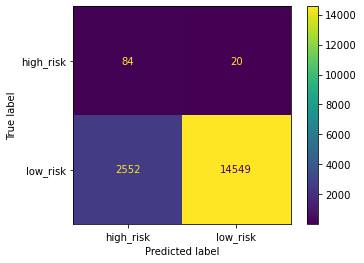

In [27]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display it neatly
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
cm_disp.plot()

In [28]:
# Print the imbalanced classification report
# baseline high risk    ----    pre: 0.71      rec:0.10      f1:0.17
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.81      0.85      0.06      0.83      0.68       104
   low_risk       1.00      0.85      0.81      0.92      0.83      0.69     17101

avg / total       0.99      0.85      0.81      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [29]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51369, 'high_risk': 51369})

In [30]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [31]:
# Calculated the balanced accuracy score
y_pred = classifier.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.8130445587977311

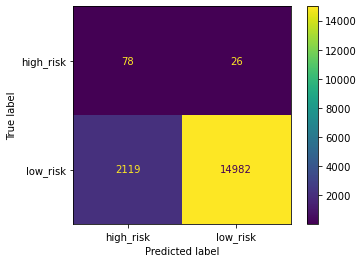

In [32]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display it neatly
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
cm_disp.plot()

In [33]:
# Print the imbalanced classification report
# baseline high risk    ----    pre: 0.71      rec:0.10      f1:0.17
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.75      0.88      0.07      0.81      0.65       104
   low_risk       1.00      0.88      0.75      0.93      0.81      0.67     17101

avg / total       0.99      0.88      0.75      0.93      0.81      0.67     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [34]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 243, 'low_risk': 243})

In [35]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(solver="lbfgs", random_state=1)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [36]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8130445587977311

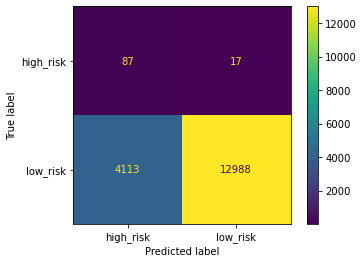

In [37]:
# predict y and display the confusion matrix
y_pred = classifier.predict(X_test)

# neatly display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
cm_disp.plot()

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.84      0.76      0.04      0.80      0.64       104
   low_risk       1.00      0.76      0.84      0.86      0.80      0.63     17101

avg / total       0.99      0.76      0.84      0.86      0.80      0.63     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [39]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [40]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(solver="lbfgs", random_state=1)
classifier.fit(X_resampled, y_resampled)

y_pred = classifier.predict(X_test)

In [41]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8187712819313311

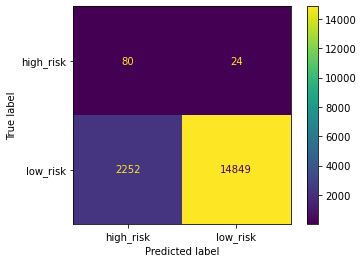

In [42]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
cm_disp.plot()

In [43]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.77      0.87      0.07      0.82      0.66       104
   low_risk       1.00      0.87      0.77      0.93      0.82      0.67     17101

avg / total       0.99      0.87      0.77      0.92      0.82      0.67     17205

